In [1]:
from stable_baselines3 import DQN, PPO
from utils import *
from data_logger import DataLogger
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
#Loading parameters
ep, lp, hp = get_params() #params["environment"], params["logging"], params["hyperparameters"]
hp_algo = hp['ppo']

In [3]:
#Environment
from gym.wrappers.gray_scale_observation import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
env = get_env(game=ep["game"], level=ep["level"], action_space=ep["action_space"])
env = apply_wrappers(env, skip=ep["skip"], gray_scale=ep["gray_scale"], shape=ep["frame_shape"], num_stack=ep["num_stack"])
next_state = env.reset()
print(next_state.shape)


(240, 256, 3)


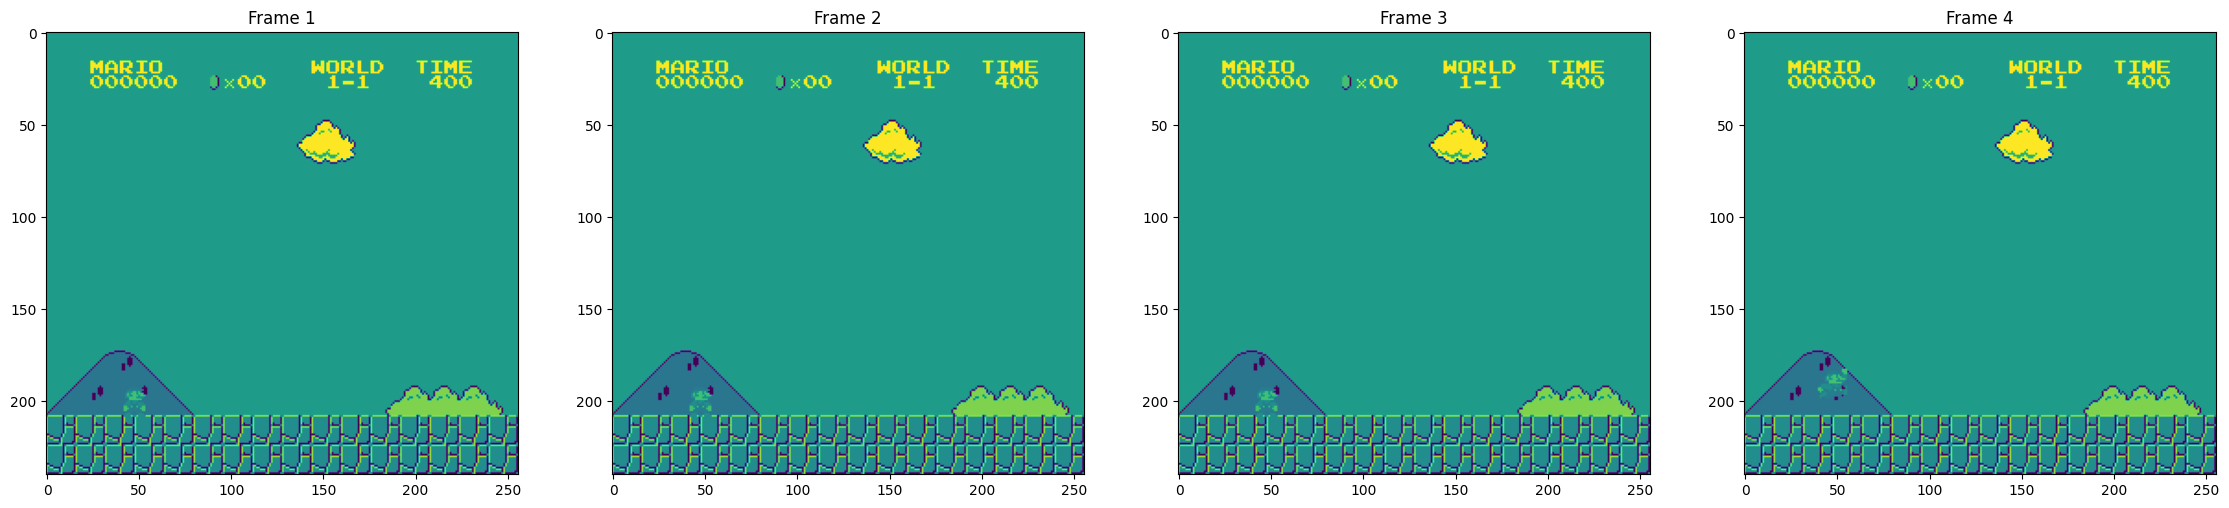

In [4]:
#from utils import *
next_state, reward, done, info = env.step(get_action_sample(env))
plot_sequence_observations(next_state)

In [4]:
#Logging
from stable_baselines3.common.callbacks import BaseCallback
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting winrate in tensorboard and saving hyperparameters.
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)
        #Saving hyperparameters
        save_hyperparameters(hp, logger.folder_path_train)

    def _on_step(self) -> bool:
        self.logger.record("rollout/winrate_mean", int(self.locals["infos"][0]["flag_get"]))
        return True

logger = DataLogger(env, model=hp_algo["model"])
checkpoint_callback = CheckpointCallback(save_freq=lp["n_time_steps_save_model"], save_path=logger.folder_path_models, name_prefix="chkpt")#saving the model periodically
eval_callback = EvalCallback(env, best_model_save_path=logger.folder_path_models, log_path=logger.folder_path_models, eval_freq=lp["evaluate_best_model_every"], deterministic=True, render=False)#evaluating the model periodically and saving the best one
log_callback = TensorboardCallback()

In [5]:
#Hyperparams DQN
# model = DQN("CnnPolicy",
#             env,
#             double_dqn = (hp_algo["model"]=="DDQN"), 
#             buffer_size = hp_algo["buffer_size"],
#             batch_size = hp_algo["batch_size"],
#             learning_starts = hp_algo["learning_starts"],
#             learning_rate = hp_algo["learning_rate"],
#             gamma = hp_algo["discount_factor"],  
#             exploration_fraction = hp_algo["exploration_fraction"],
#             exploration_final_eps = hp_algo["exploration_final_eps"],
#             train_freq = hp_algo["train_freq"],                    
#             target_update_interval = hp_algo["target_update_interval"],   
#             tensorboard_log = logger.folder_path_train,
#             verbose = 1,
#             device = device
#             )

In [6]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=logger.folder_path_train, learning_rate=hp_algo["learning_rate"], device = device)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [7]:
model.learn(total_timesteps=hp_algo["time_steps"],
            callback=[log_callback, checkpoint_callback, eval_callback],
            tb_log_name="adding_masskip")

Logging to logs\SuperMarioBros-1-1-v0\PPO\20240129065904\train\adding_masskip_1


e:\10mociclo\Applied\RL_Sonic-TheHedgehog\venv38\lib\site-packages\stable_baselines3\common\callbacks.py:403: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x000002509BF23CD0> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x00000250FA297A30>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 389      |
|    ep_rew_mean     | 661      |
|    winrate_mean    | 0        |
| time/              |          |
|    fps             | 78       |
|    iterations      | 1        |
|    time_elapsed    | 26       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 414         |
|    ep_rew_mean          | 651         |
|    winrate_mean         | 0           |
| time/                   |             |
|    fps                  | 59          |
|    iterations           | 2           |
|    time_elapsed         | 68          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011973902 |
|    clip_fraction        | 0.0882      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94     

e:\10mociclo\Applied\RL_Sonic-TheHedgehog\venv38\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=250000, episode_reward=-21.00 +/- 0.00
Episode length: 2005.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 2.00e+03  |
|    mean_reward          | -21       |
| rollout/                |           |
|    winrate_mean         | 0         |
| time/                   |           |
|    total_timesteps      | 250000    |
| train/                  |           |
|    approx_kl            | 0.0639266 |
|    clip_fraction        | 0.166     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.383    |
|    explained_variance   | 0.591     |
|    learning_rate        | 3e-05     |
|    loss                 | 4.4e+03   |
|    n_updates            | 1220      |
|    policy_gradient_loss | -0.0054   |
|    value_loss           | 6.15e+03  |
---------------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean   

KeyboardInterrupt: 

In [28]:
# Load the trained model
model = PPO.load(r"logs\SuperMarioBros-1-1-v0\PPO\20240129065904\checkpoints\chkpt_2050000_steps.zip")


env = get_env(game=ep["game"], level=ep["level"], action_space=ep["action_space"])
env = apply_wrappers(env, skip=ep["skip"], gray_scale=ep["gray_scale"], shape=ep["frame_shape"], num_stack=ep["num_stack"])
# Test the model
obs = env.reset()
done = False
while not done:
    action, _ = model.predict(obs.copy())
    print(action)
    obs, _, done, _ = env.step(int(action))
    env.render()

env.close()

4


KeyboardInterrupt: 

In [27]:
env.close()

ValueError: env has already been closed.

In [ ]:
try:
    while True:
        time_stamp=0
        state = env.reset()
        while time_stamp<1e4:
            action_idx = agent.act(state)

            next_state, reward, done, info = env.step(get_action(action_idx, env))

            state = next_state

            env.render()
            
            time_stamp += 1

            if done or info["flag_get"]:
                break
except:
    env.close()